In [1]:
# Python 3.9.5
# qpsolvers 4.0.0
# SCS 3.2.3
# Mosek 10.1

In [2]:
%matplotlib inline

In [3]:
from grale.all_nb import *
import glob
import os
from IPython.display import display, HTML
import subprocess

renderers.setDefaultMassRenderer(None)
renderers.setDefaultLensPlaneRenderer(None)

Set 'threads' as default renderer for lensplane and mass density
Set default angular unit in plotting to arcsec
Set feedback style to 'notebook'


In [4]:
cosm = cosmology.Cosmology(0.7, 0.27, 0, 0.73)
D = cosm.getAngularDiameterDistance
cosmology.setDefaultCosmology(cosm)

zd = 0.68
zs1 = 1.734

critDens = lenses.getCriticalDensity(D(zd), D(zs1), D(zd,zs1))

In [5]:
lens = lenses.GravitationalLens.load("avglens_j10044112_2024.lensdata")

In [6]:
%%time

if os.path.exists("avgmodel_psidetailed.lensdata"):
    psiLens = lenses.GravitationalLens.load("avgmodel_psidetailed.lensdata")
else:
    lenses.experimentalThreads = True
    
    # First build an approximation to work with more easily
    blDetail, trDetail = V(-30,-30)*ANGLE_ARCSEC, V(40,40)*ANGLE_ARCSEC
    Ndetail = 2048
    thetas = util.createThetaGrid(blDetail, trDetail, Ndetail, Ndetail)
    psi = lens.getProjectedPotential(1, 1, thetas)
    psiLens = lenses.PotentialGridLens(D(zd), { "values": psi, "bottomleft": blDetail, "topright": trDetail })
    psiLens.save("avgmodel_psidetailed.lensdata")
    
    lenses.experimentalThreads = False
    
print("psiLens shape", psiLens.getLensParameters()["values"].shape)

psiLens shape (2048, 2048)
CPU times: user 507 ms, sys: 35.9 ms, total: 543 ms
Wall time: 543 ms


In [7]:
liPsiLens = plotutil.LensInfo(psiLens, size=35*ANGLE_ARCSEC, center=V(5,5)*ANGLE_ARCSEC, zd=zd, zs=zs1)

In [8]:
imgList = images.readInputImagesFile("SDSSJ1004points.txt", True)
iws = inversion.InversionWorkSpace(zd, 40*ANGLE_ARCSEC)
for i in imgList:
    iws.addImageDataToList(i["imgdata"], i["z"], "pointimages")

In [9]:
def getEquivLens(N, gradPotWeight, densWeight, solver, pixelEnlargements=2, diag=False):
    
    if pixelEnlargements == 2 and not diag:
        fn = f"eq_model-N_{N}-gpw_{gradPotWeight}-dw_{densWeight}-s_{solver}.lensdata"
    else:
        if not diag:
            fn = f"eq_model-N_{N}-gpw_{gradPotWeight}-dw_{densWeight}-s_{solver}-pe_{pixelEnlargements}.lensdata"
        else:
            fn = f"eq_model-N_{N}-gpw_{gradPotWeight}-dw_{densWeight}-s_{solver}-pe_{pixelEnlargements}-diag.lensdata"

    if os.path.exists(fn):
        return lenses.GravitationalLens.load(fn)
    
    bl = -V(25,25)*ANGLE_ARCSEC
    tr = V(35,35)*ANGLE_ARCSEC

    BW=5
    border = np.zeros((N,N), dtype=bool)
    border[:BW,:] = True
    border[-BW:,:] = True
    border[:,:BW] = True
    border[:,-BW:] = True
    r = lenses.createEquivalentPotentialGridLens(psiLens, bl, tr, N, N, [ i["imgdata"] for i in imgList ],
                                                 gradPotWeight, 1, densWeight,
                                                 exactDensityConstraints=[{
                                                     "maskRegions": [ border ],
                                                     "density": 0
                                                 }],
                                                 qpsolver=solver, feedbackObject="stdout")

    newPsiLens = r["philens_equiv"]
    newPsiLens.save(fn)
    return newPsiLens

In [10]:
def plotDens(li):
    zMax = 3.5
    plotutil.plotDensityContours(li, densityUnit=critDens, levels=np.arange(0.2, zMax, 0.2), linewidths=0.5, colors="black", linestyles="-")
    plotutil.plotDensityContours(li, densityUnit=critDens, levels=[1], linewidths=[2], colors="black")
    plt.gca().set_xlabel(r"$\theta_x$ (arcsec)")
    plt.gca().set_ylabel(r"$\theta_y$ (arcsec)")
    
def plotImgs():
    thetas = np.array([ pt["position"] for i in imgList for img in i["imgdata"].getAllImagePoints() for pt in img ])/ANGLE_ARCSEC
    plt.plot(thetas[:,0], thetas[:,1], 'x', color="blue", ms=5)

def createPlots(newPsiLens):
    liNewPsiLens = plotutil.LensInfo(newPsiLens, size=35*ANGLE_ARCSEC, center=V(5,5)*ANGLE_ARCSEC, zd=zd, zs=zs1)
    liNewPsiLens.getDensityPoints(feedbackObject="None")
    
    plt.figure(figsize=(5,10))
    
    plt.subplot(2,1,1)
    plotDens(liPsiLens)
    plotImgs()
    
    plt.subplot(2,1,2)
    plotDens(liNewPsiLens)
    plotImgs()

Text(value='')

FloatProgress(value=0.0)

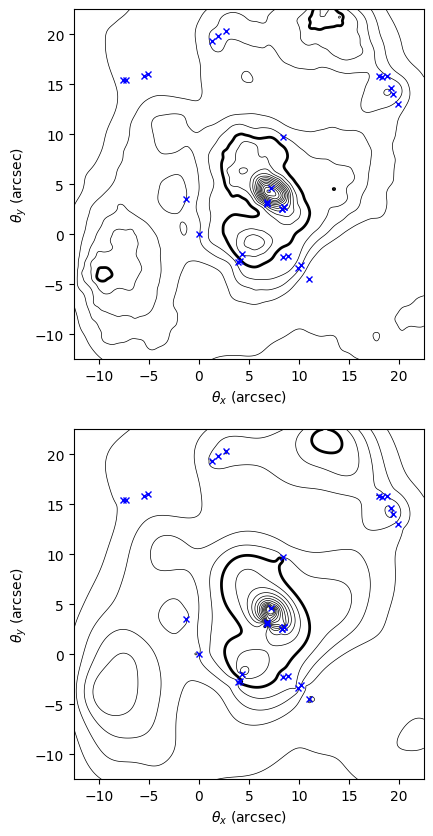

In [11]:
newPsiLens = getEquivLens(1536, 0.0001, 0.1, "scs", 4)
createPlots(newPsiLens)